In [6]:
import pandas as pd
import numpy as np
from statsmodels.tsa.seasonal import STL
from sklearn.ensemble import IsolationForest
from plotnine import ggplot, geom_line, facet_wrap, aes, scale_fill_gradient2, theme, labs, geom_point, scale_color_manual, \
geom_text, scale_fill_gradient2, theme_minimal, geom_boxplot, geom_tile, scale_x_discrete,element_text,scale_y_discrete
from pandas.api.types import CategoricalDtype

from ydata_profiling import ProfileReport

In [7]:
pd.set_option('display.max_rows', 100)

df = pd.read_csv('../data/ground_station_clean.csv')
df['Timestamp'] = pd.to_datetime(df['Timestamp'])
df.head()

,Timestamp,Longitude,Latitude,Temperature,Humidity,Wind_Speed_kmh,Soil_Moisture,Soil_Temperature,Wind_Dir_Sin,Wind_Dir_Cos,Precipitation_accumulated
0,2024-06-01 00:00:00,-119.591264,49.886552,3.360417,93.850000,2.058333,9123.333333,3.805833,-0.924989,0.379994,0.0
1,2024-06-01 01:00:00,-119.591264,49.886552,7.297917,89.512500,1.539167,9100.666667,5.378750,0.463038,-0.886338,0.0
2,2024-06-01 02:00:00,-119.591264,49.886552,9.898333,83.608333,1.136250,9092.000000,8.674167,0.982178,-0.187953,0.0
3,2024-06-01 03:00:00,-119.591264,49.886552,12.027917,75.337500,2.122917,9110.000000,12.669167,0.168633,-0.985679,0.0
4,2024-06-01 04:00:00,-119.591264,49.886552,14.480833,69.791667,2.089167,9132.666667,15.624583,-0.001454,-0.999999,0.0


In [8]:
print(df.isna().sum())

Timestamp                    0
Longitude                    0
Latitude                     0
Temperature                  0
Humidity                     0
Wind_Speed_kmh               0
Soil_Moisture                0
Soil_Temperature             0
Wind_Dir_Sin                 0
Wind_Dir_Cos                 0
Precipitation_accumulated    0
dtype: int64


In [9]:
def get_season(date):
    return ['Winter', 'Spring', 'Summer', 'Autumn'][(date.month % 12) // 3]
df['Season'] = df['Timestamp'].apply(get_season)
df.head()

,Timestamp,Longitude,Latitude,Temperature,Humidity,Wind_Speed_kmh,Soil_Moisture,Soil_Temperature,Wind_Dir_Sin,Wind_Dir_Cos,Precipitation_accumulated,Season
0,2024-06-01 00:00:00,-119.591264,49.886552,3.360417,93.850000,2.058333,9123.333333,3.805833,-0.924989,0.379994,0.0,Summer
1,2024-06-01 01:00:00,-119.591264,49.886552,7.297917,89.512500,1.539167,9100.666667,5.378750,0.463038,-0.886338,0.0,Summer
2,2024-06-01 02:00:00,-119.591264,49.886552,9.898333,83.608333,1.136250,9092.000000,8.674167,0.982178,-0.187953,0.0,Summer
3,2024-06-01 03:00:00,-119.591264,49.886552,12.027917,75.337500,2.122917,9110.000000,12.669167,0.168633,-0.985679,0.0,Summer
4,2024-06-01 04:00:00,-119.591264,49.886552,14.480833,69.791667,2.089167,9132.666667,15.624583,-0.001454,-0.999999,0.0,Summer


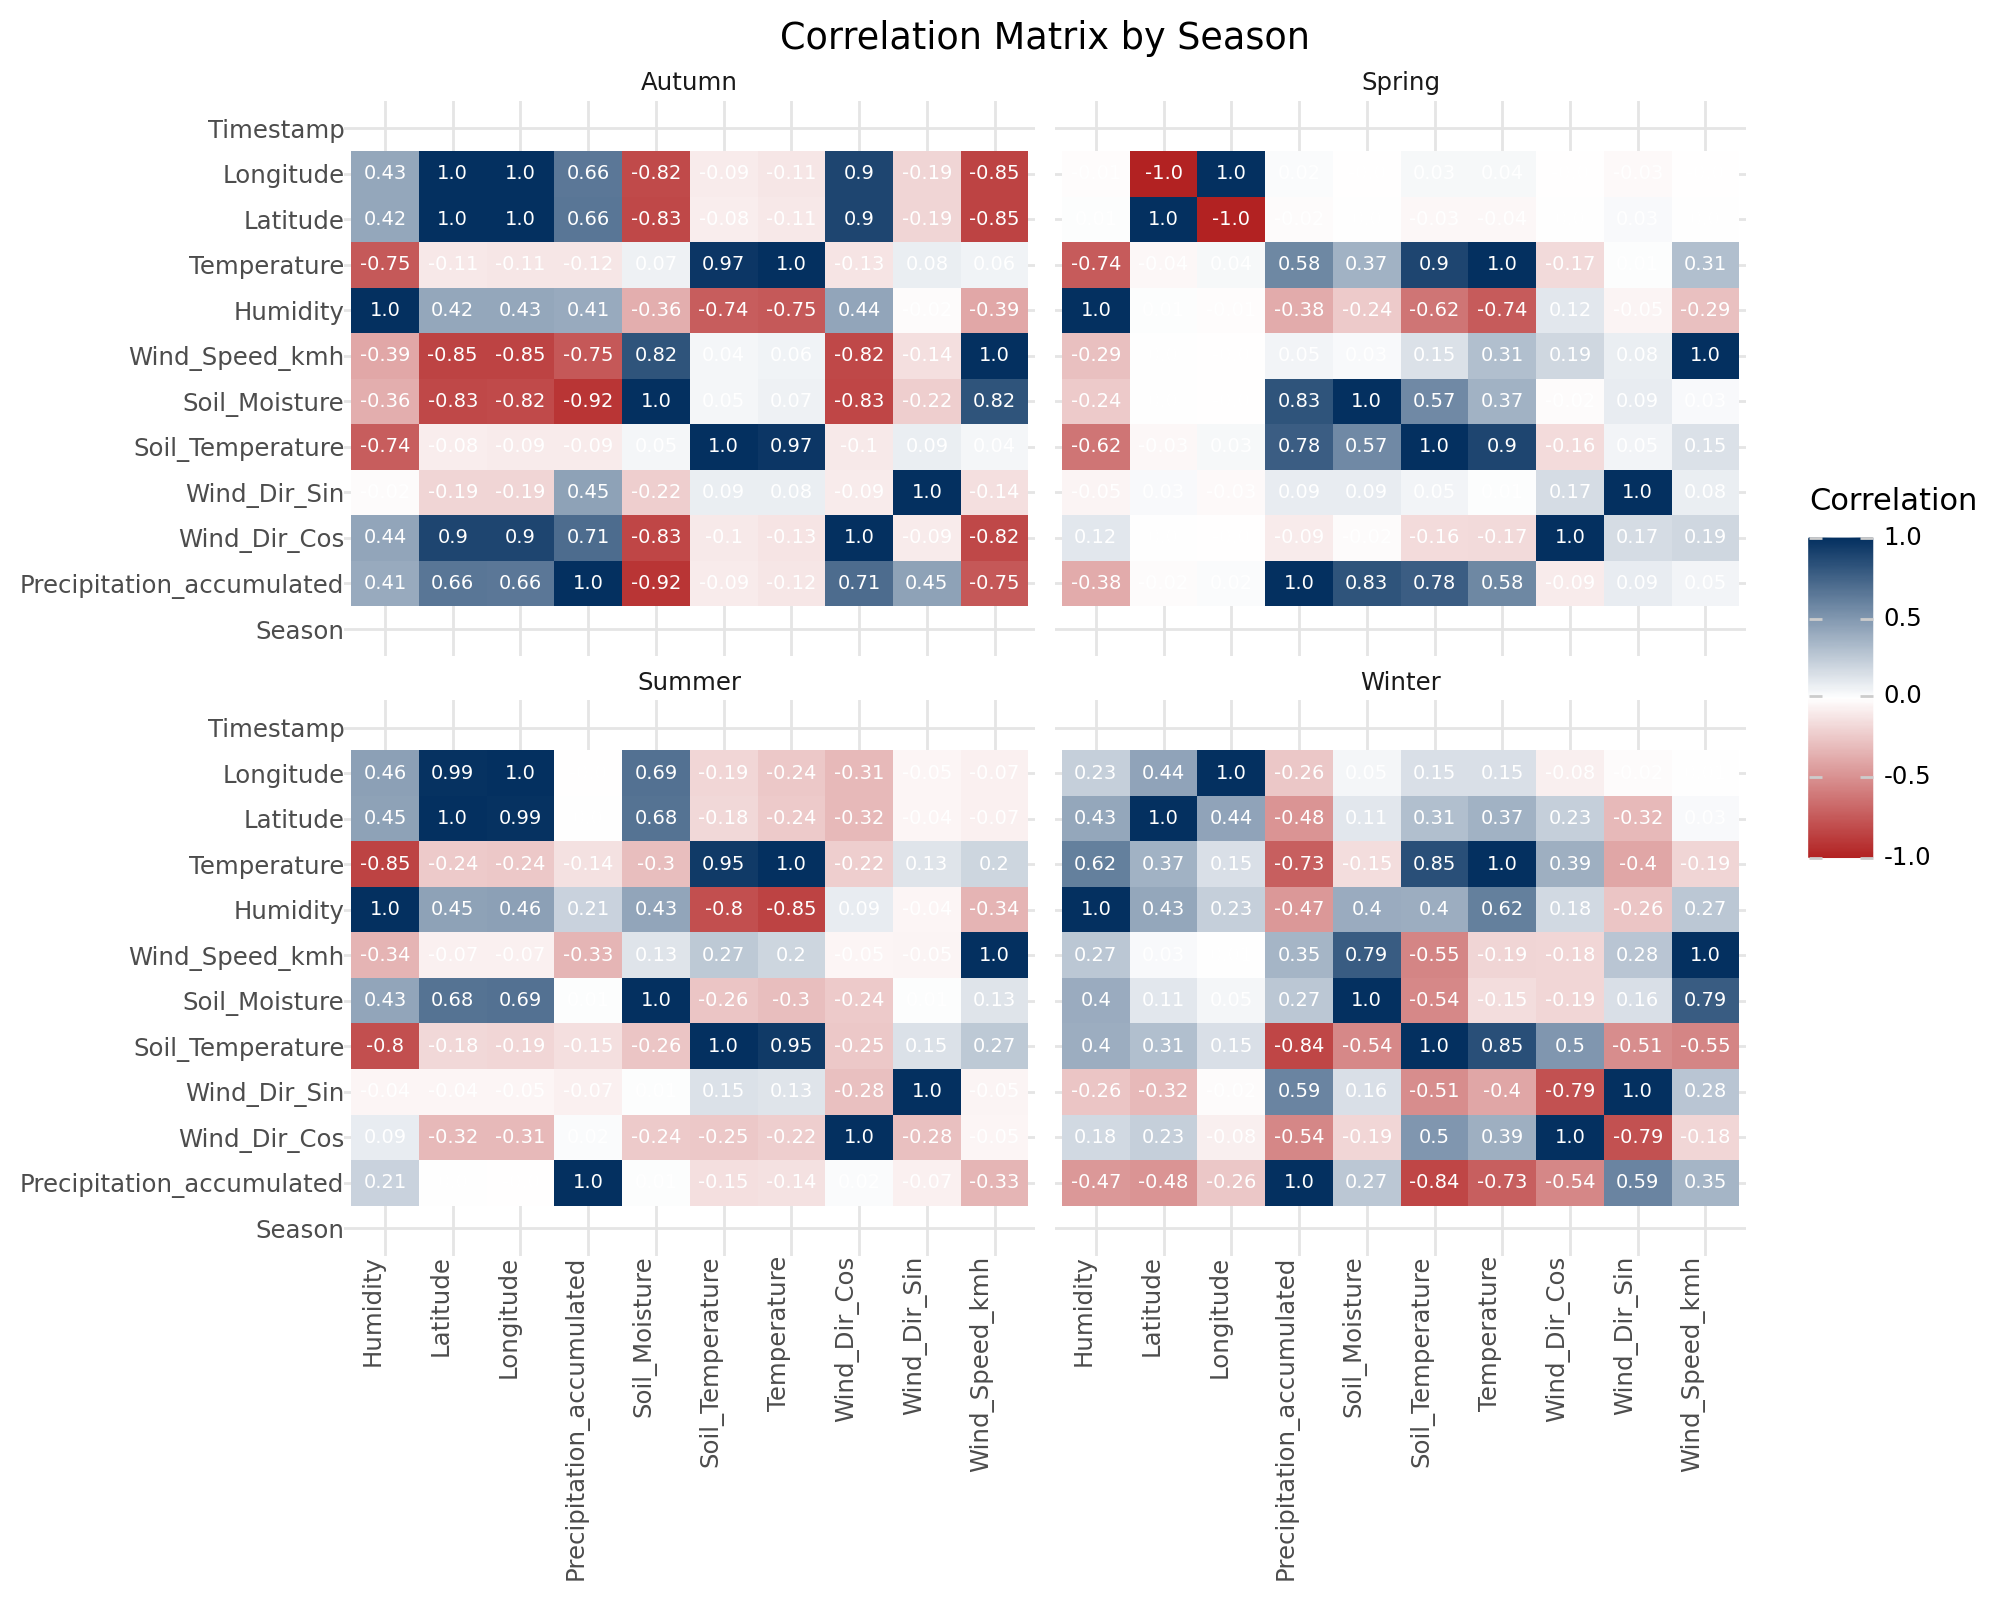

In [10]:
# Create an empty list to store long-form correlation data per season
season_corrs = []

# Loop through each season to calculate correlations
for season, group in df.groupby('Season'):
    numeric_group = group.select_dtypes(include='number')
    corr = numeric_group.corr().reset_index().melt(id_vars='index')
    corr.columns = ['Variable1', 'Variable2', 'Correlation']
    corr['Season'] = season
    season_corrs.append(corr)

# Combine all into a single DataFrame
corr_long = pd.concat(season_corrs)


# Plot with facet for each season
plot = (
    ggplot(corr_long, aes(x='Variable1', y='Variable2', fill='Correlation')) +
    geom_tile() +
    geom_text(aes(label='round(Correlation, 2)'), color='white', size=7) +
    scale_fill_gradient2(low='firebrick', mid='white', high='#043060', midpoint=0) +
    scale_y_discrete(limits=df.columns[::-1]) +
    theme_minimal() +
    theme(
        figure_size=[10,8],
        axis_text_x=element_text(rotation=90, ha='right', va='top')
    ) +
    facet_wrap('~Season') +
    labs(title='Correlation Matrix by Season', x='', y='')
)

plot.show()

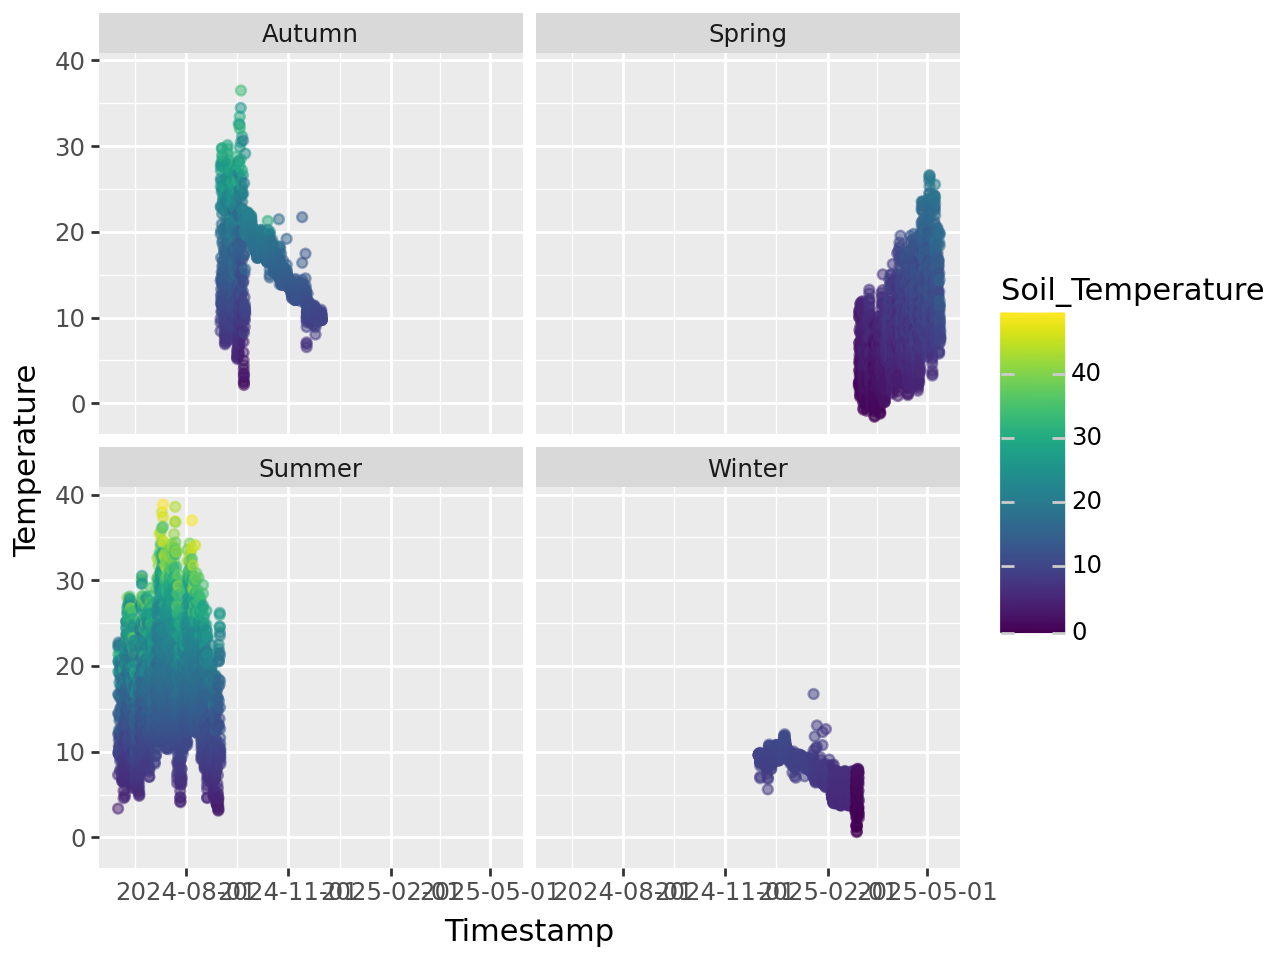

In [13]:
# verificar temperatura
p = (
    ggplot(df)
    + geom_point(aes(x='Timestamp', y='Temperature', color='Soil_Temperature'), alpha=0.5)
    + facet_wrap('~Season')
)
p.show()

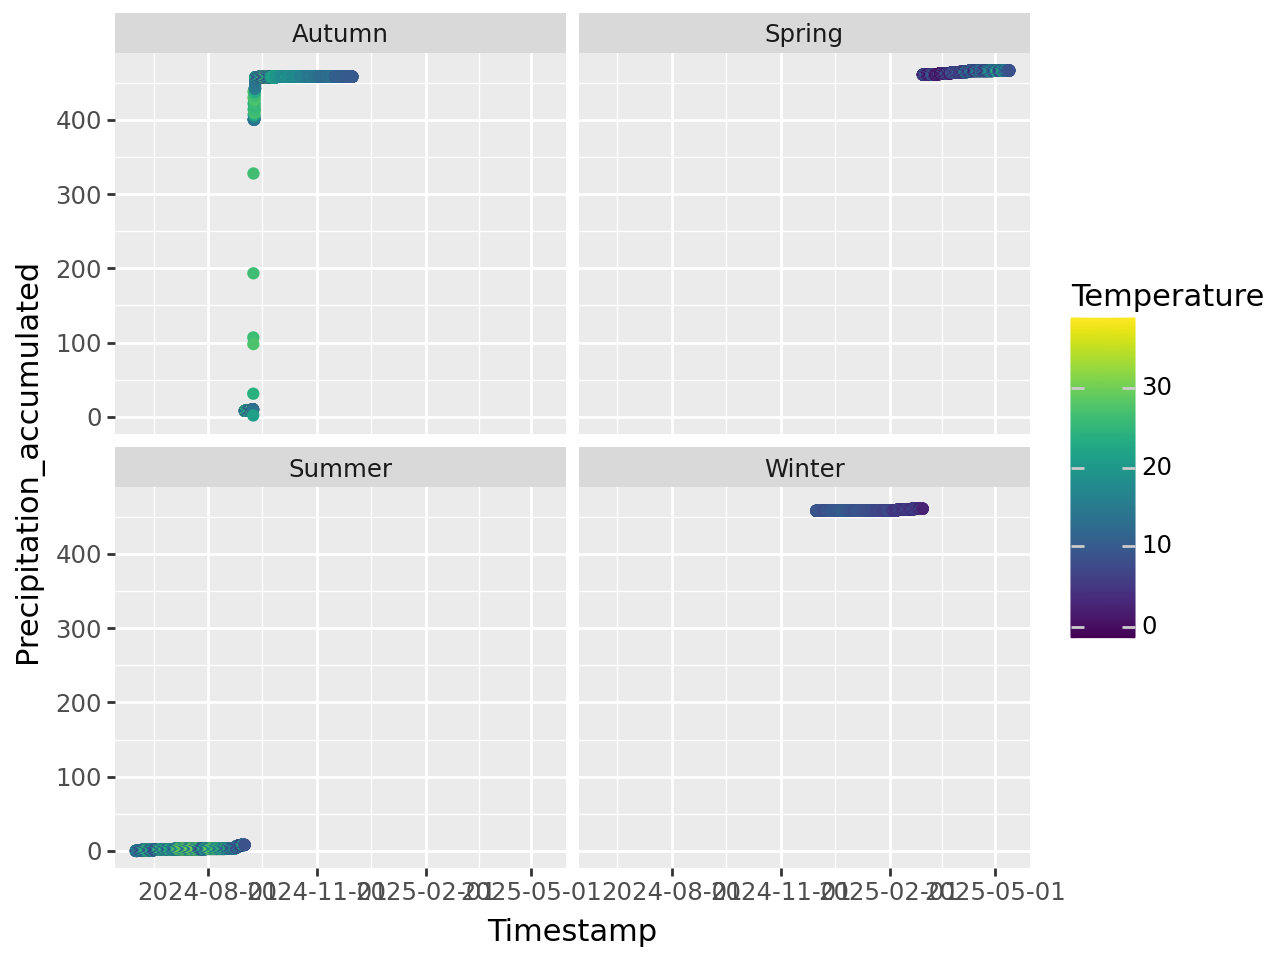

In [14]:
# verificar correlação temperatura e precipitação
p = (
    ggplot(df)
    + geom_point(aes(x='Timestamp', y='Precipitation_accumulated', color='Temperature'))
    + facet_wrap('~Season')
)
p.show()

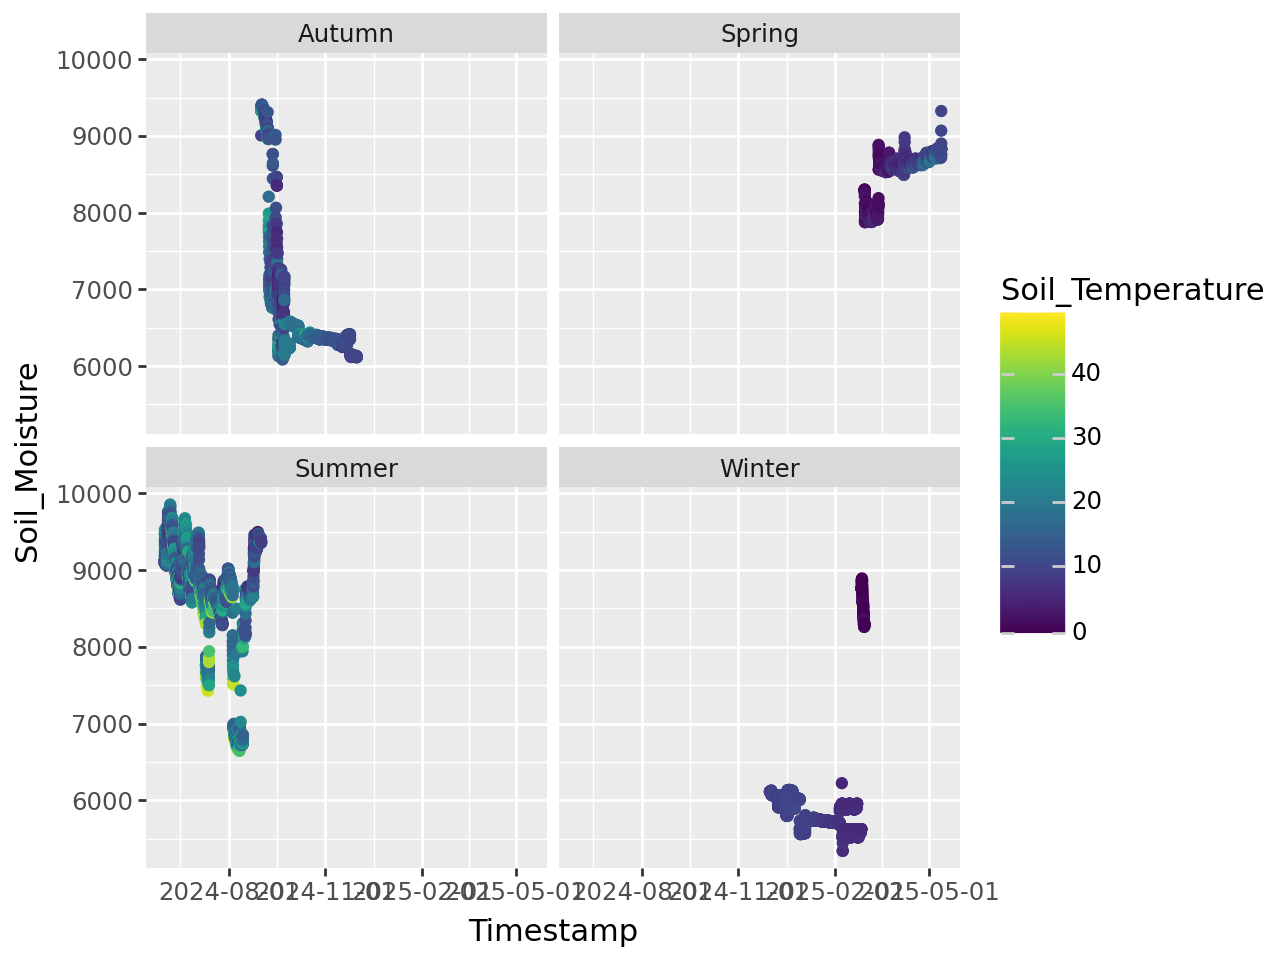

In [15]:
# verificar correlação umidade do solo e temperatura do solo
p = (
    ggplot(df)
    + geom_point(aes(x='Timestamp', y='Soil_Moisture', color='Soil_Temperature'))
    + facet_wrap('~Season')
)
p.show()

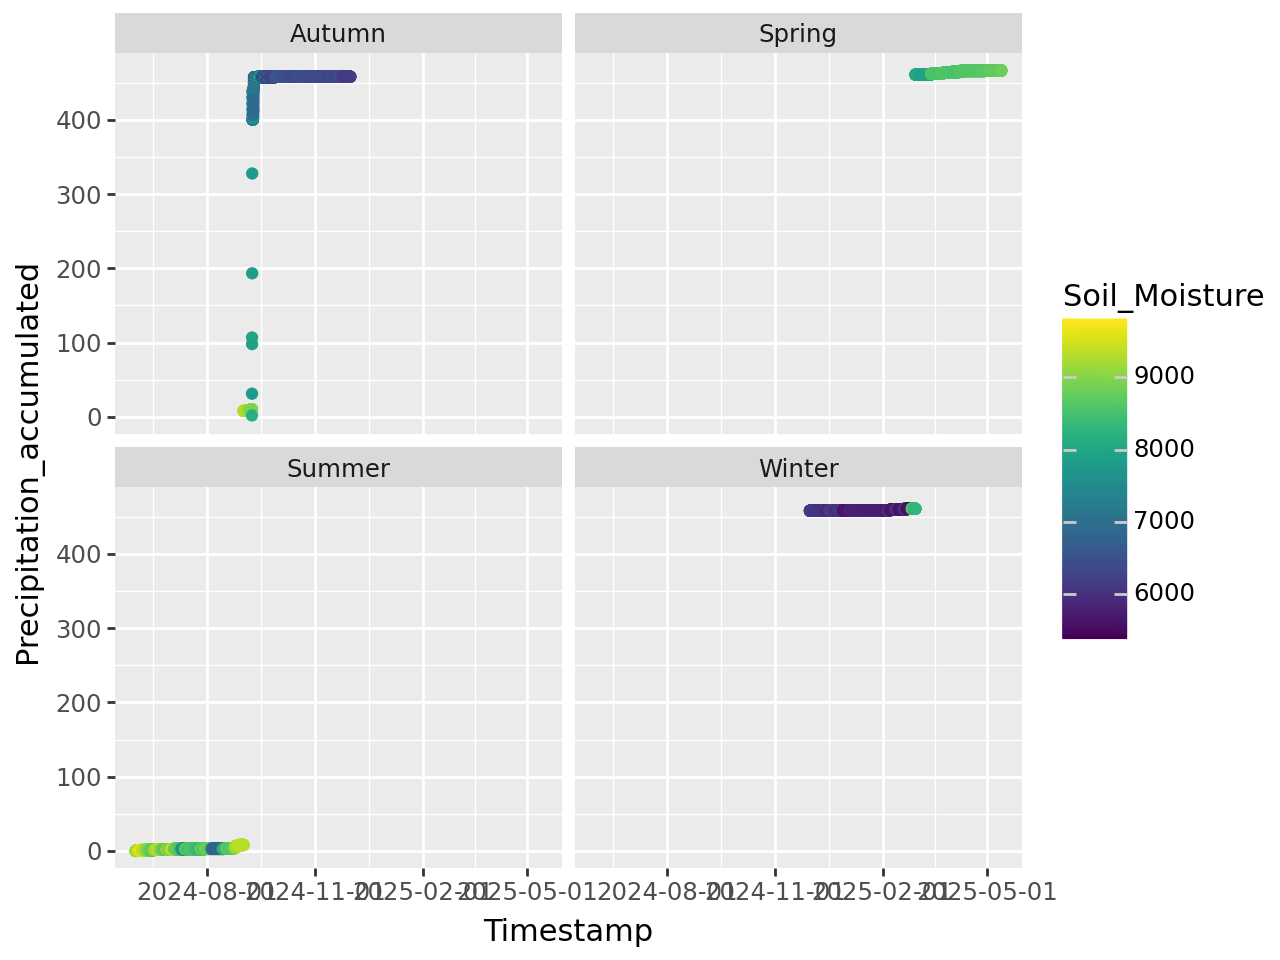

In [17]:
# verificar correlação umidade do solo e precipitação
p = (
    ggplot(df)
    + geom_point(aes(x='Timestamp', y='Precipitation_accumulated', color='Soil_Moisture'))
    + facet_wrap('~Season')
)
p.show()

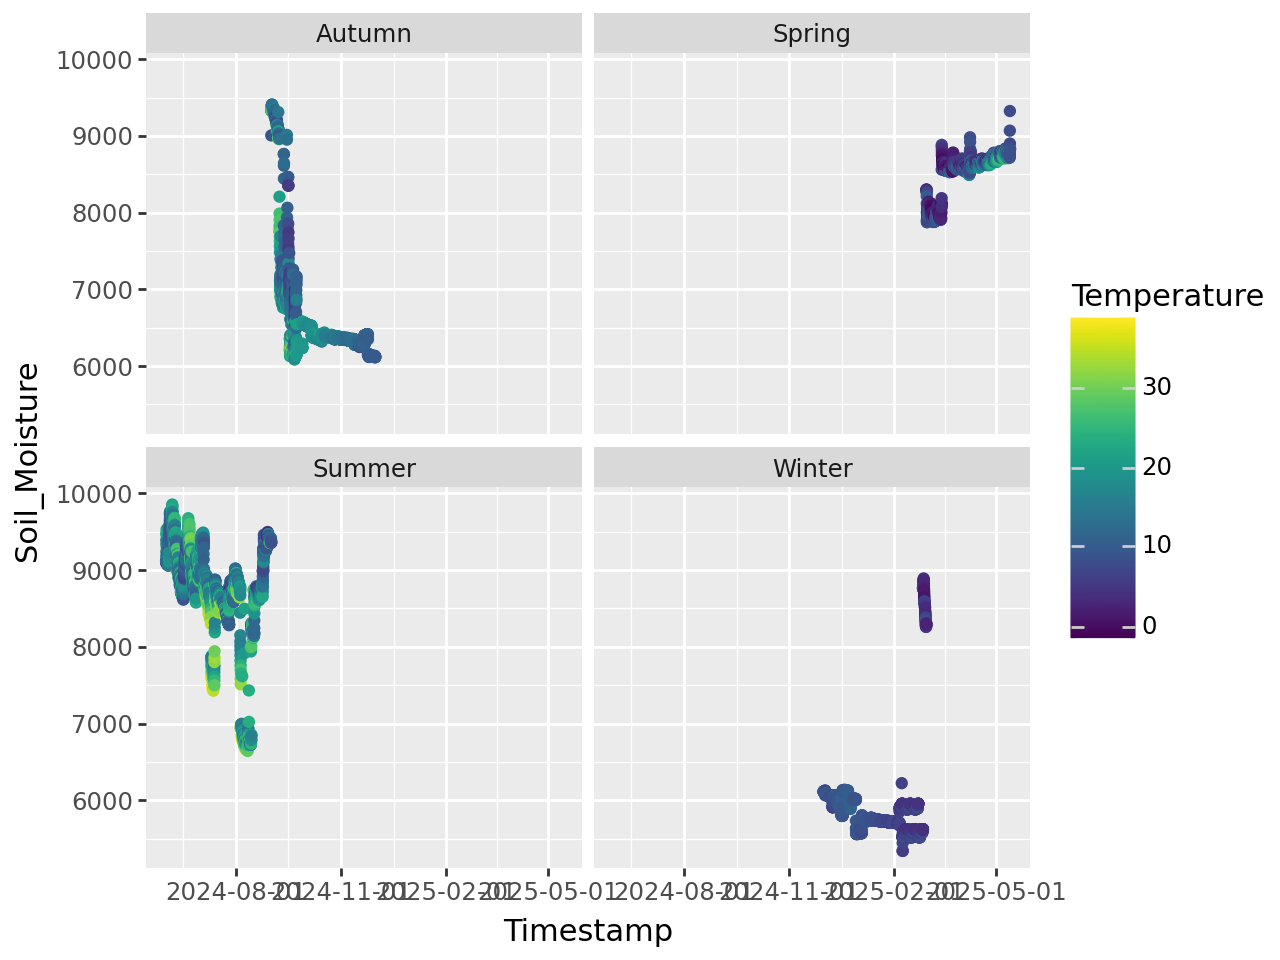

In [18]:
# verificar correlação umidade do solo e temperatura
p = (
    ggplot(df)
    + geom_point(aes(x='Timestamp', y='Soil_Moisture', color='Temperature'))
    + facet_wrap('~Season')
)
p.show()

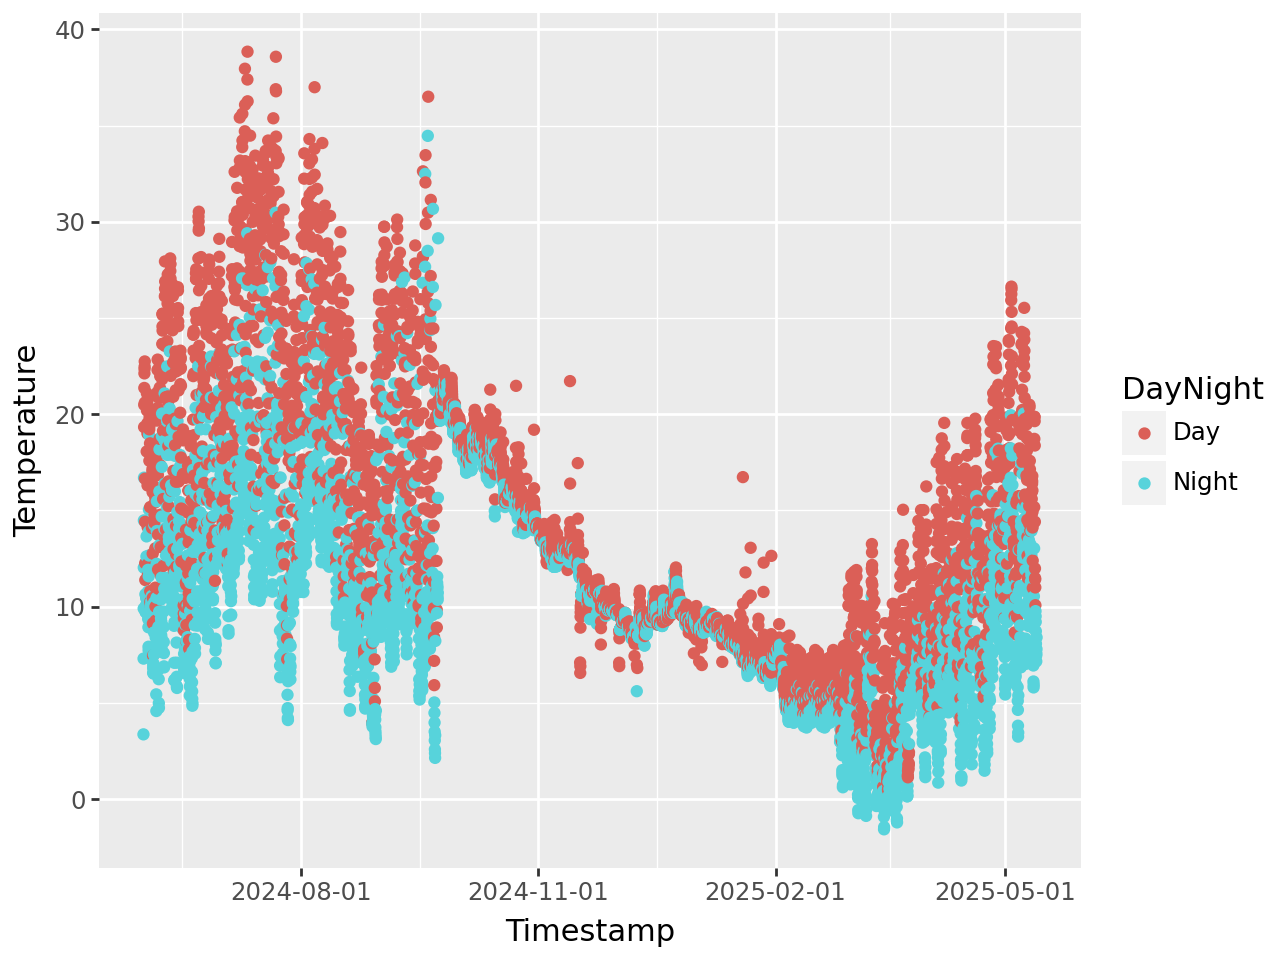

In [19]:
# definir as estações do ano
df['Timestamp'] = pd.to_datetime(df['Timestamp'])
df['Season'] = df['Timestamp'].apply(get_season)

# define se a hora é de dia ou de noite 6h até as 18h é considerado dia o resto é noite
df['Hour'] = df['Timestamp'].dt.hour
df['DayNight'] = df['Hour'].apply(lambda h: 'Day' if 6 <= h < 18 else 'Night')

# verificar temperatura do solo vs temperatura normal de noite e de dia
p = (
    ggplot(df)
    + geom_point(aes(x="Timestamp", y="Temperature", color='DayNight'))
)
p.show()

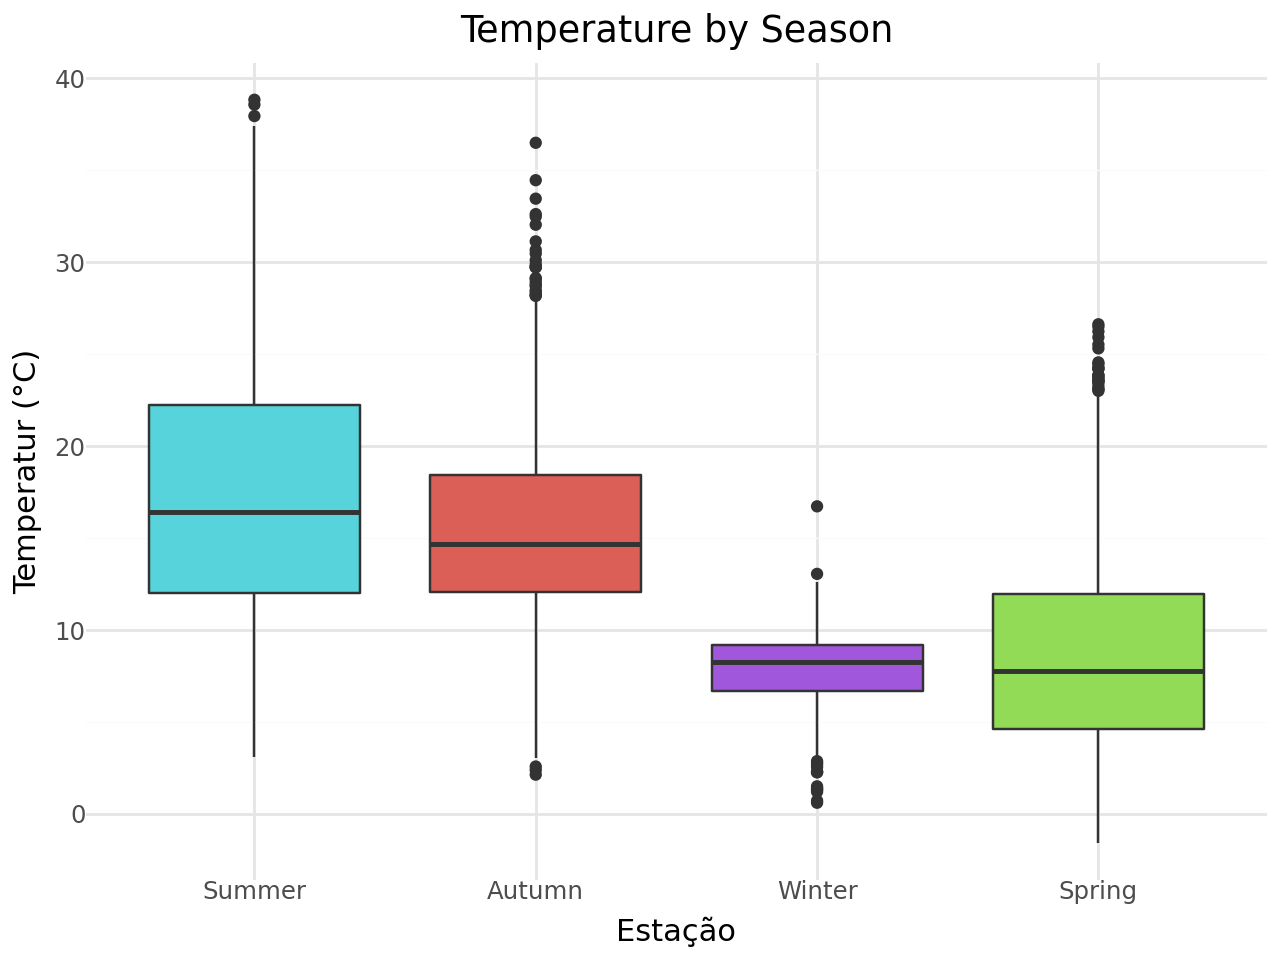

In [20]:
season_order = df['Season'].astype(str).drop_duplicates().tolist()

plot = (
    ggplot(df, aes(x='Season', y='Temperature', fill='Season'))
    + geom_boxplot(show_legend=False)
    + scale_x_discrete(limits=season_order)  # aqui
    + theme_minimal()
    + labs(
        title='Temperature by Season',
        x='Estação',
        y='Temperatur (°C)'
    )
)
plot.show()

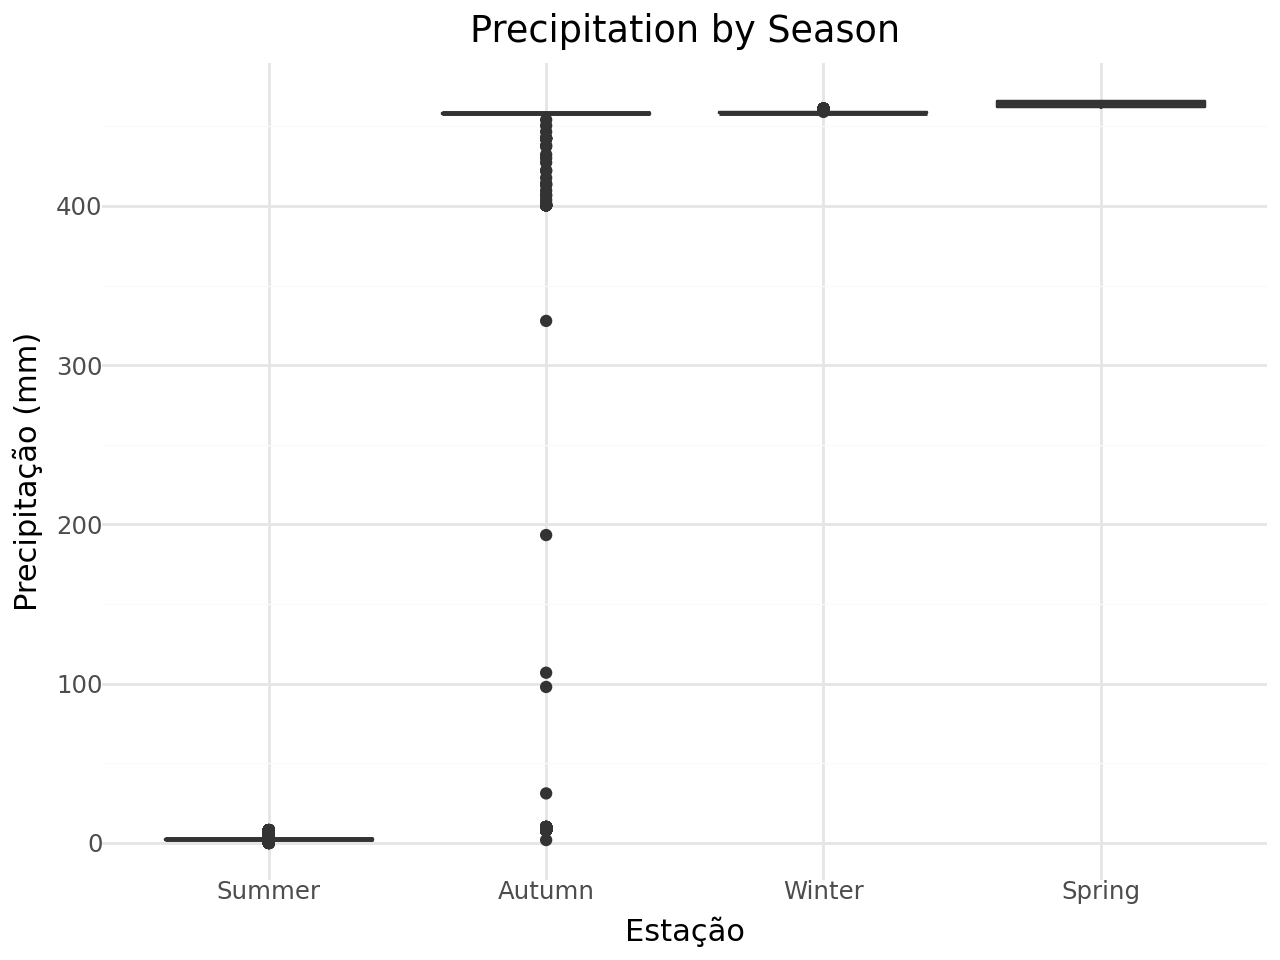

In [22]:
plot = (
    ggplot(df, aes(x='Season', y='Precipitation_accumulated', fill='Season'))
    + geom_boxplot(show_legend=False)
    + scale_x_discrete(limits=season_order)  # aqui
    + theme_minimal()
    + labs(
        title='Precipitation by Season',
        x='Estação',
        y='Precipitação (mm)'
    )
)
plot.show()

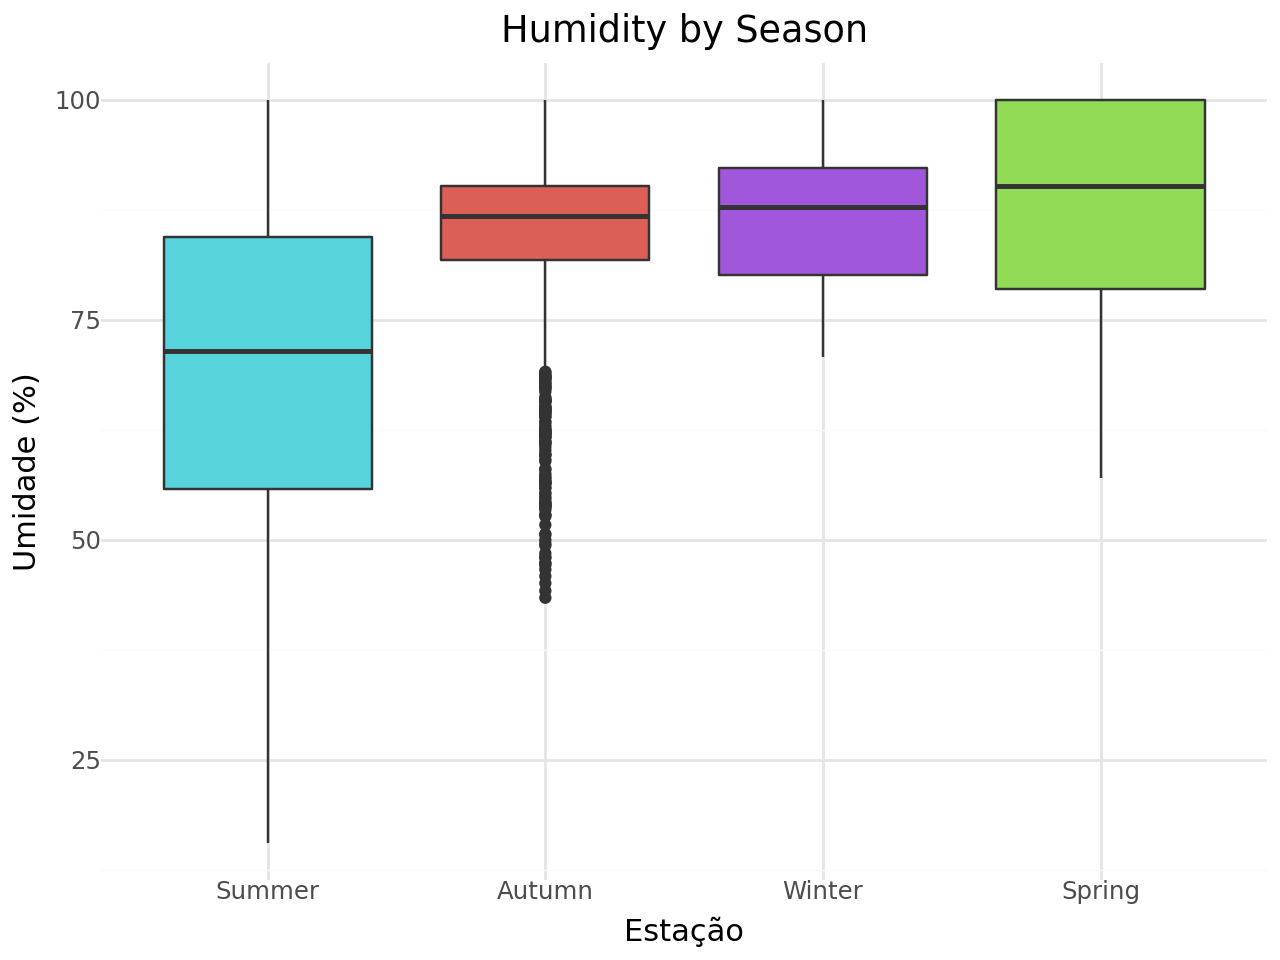

In [23]:
plot = (
    ggplot(df, aes(x='Season', y='Humidity', fill='Season'))
    + geom_boxplot(show_legend=False)
    + scale_x_discrete(limits=season_order)  # aqui
    + theme_minimal()
    + labs(
        title='Humidity by Season',
        x='Estação',
        y='Umidade (%)'
    )
)
plot.show()

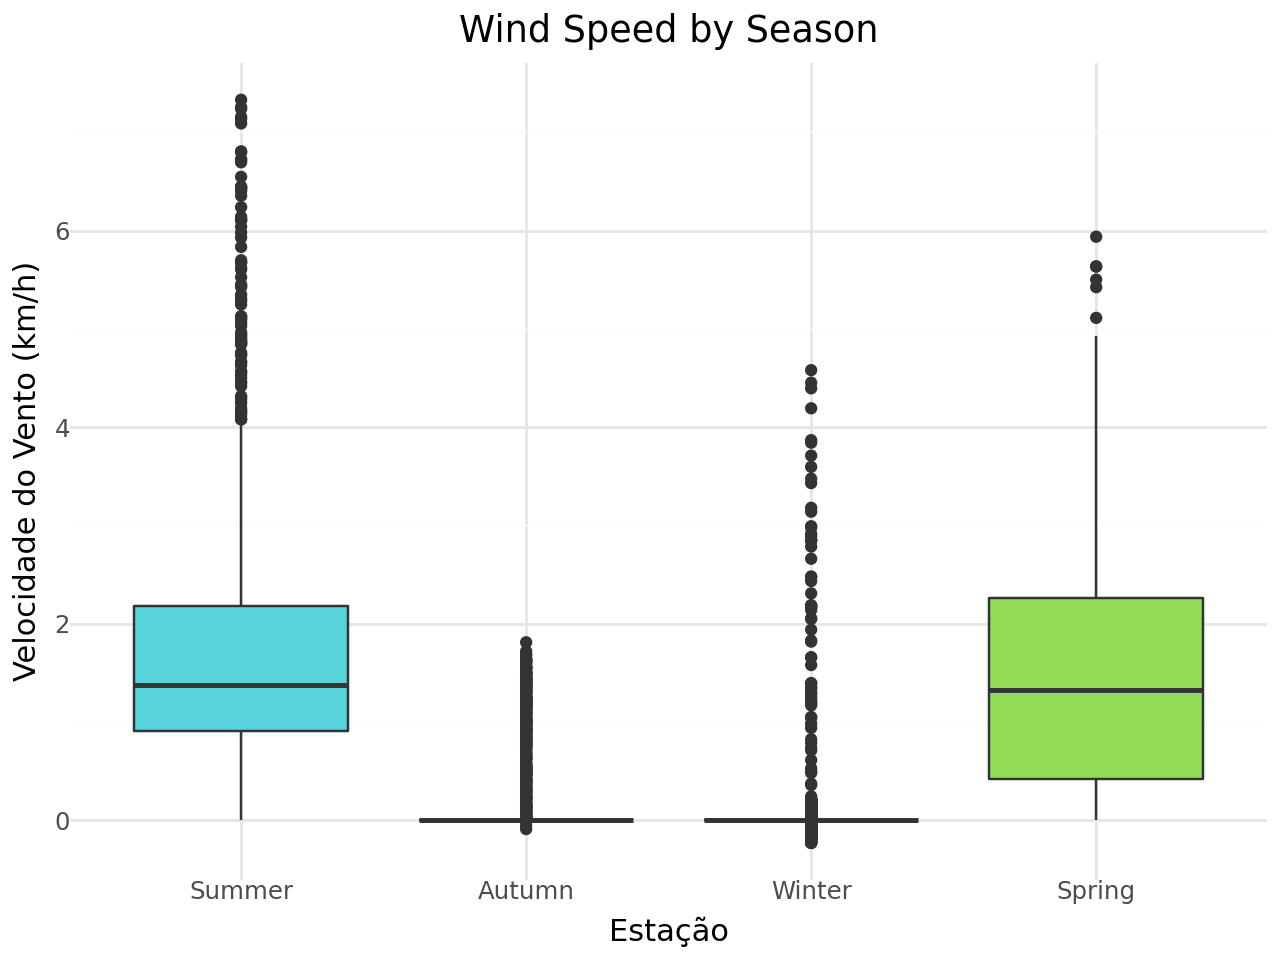

In [24]:
plot = (
    ggplot(df, aes(x='Season', y='Wind_Speed_kmh', fill='Season'))
    + geom_boxplot(show_legend=False)
    + scale_x_discrete(limits=season_order)  # aqui
    + theme_minimal()
    + labs(
        title='Wind Speed by Season',
        x='Estação',
        y='Velocidade do Vento (km/h)'
    )
)
plot.show()

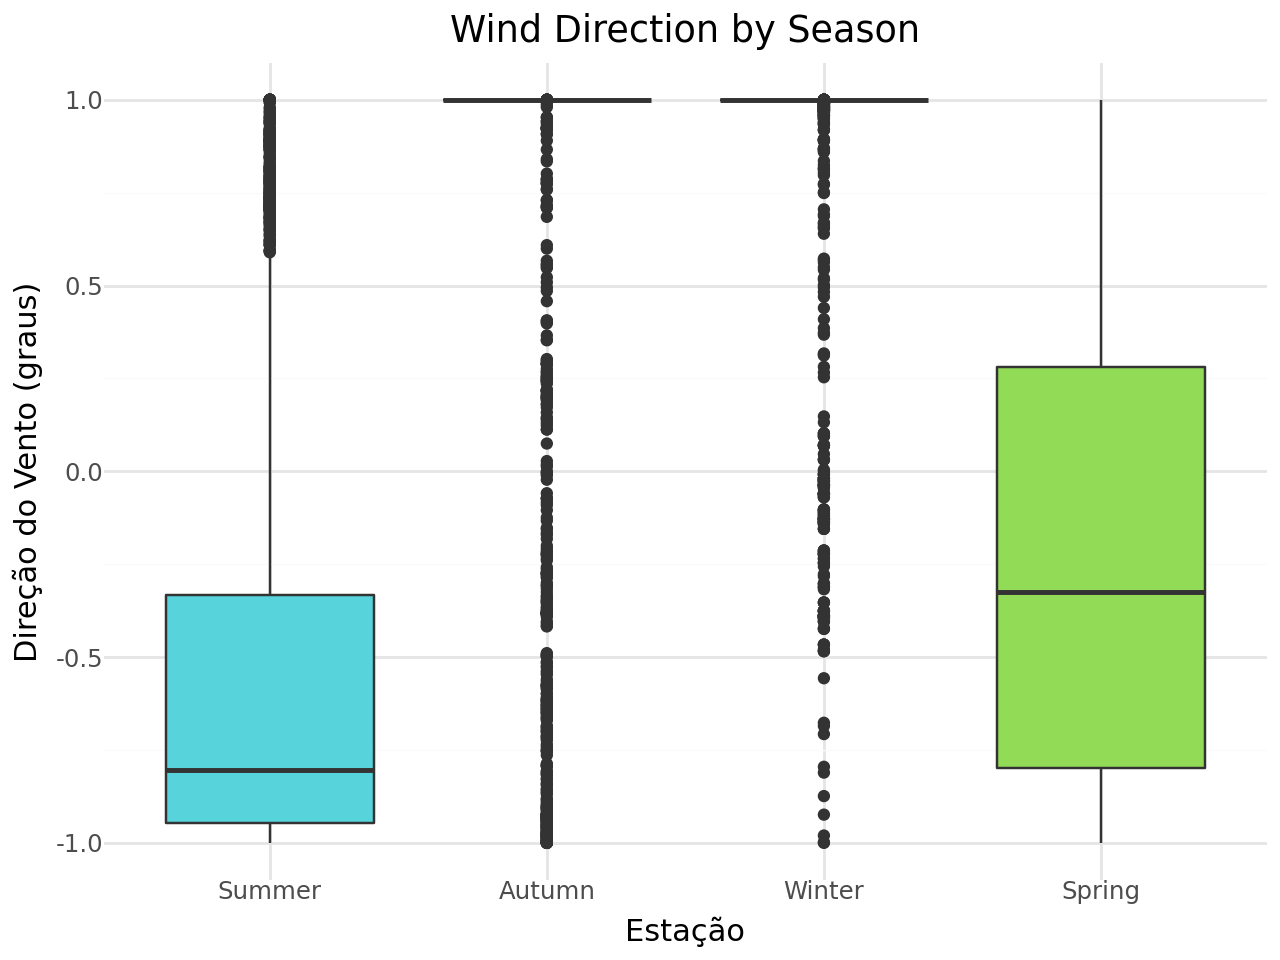

In [27]:
plot = (
    ggplot(df, aes(x='Season', y='Wind_Dir_Cos', fill='Season'))
    + geom_boxplot(show_legend=False)
    + scale_x_discrete(limits=season_order)  # aqui
    + theme_minimal()
    + labs(
        title='Wind Direction by Season',
        x='Estação',
        y='Direção do Vento (graus)'
    )
)
plot.show()

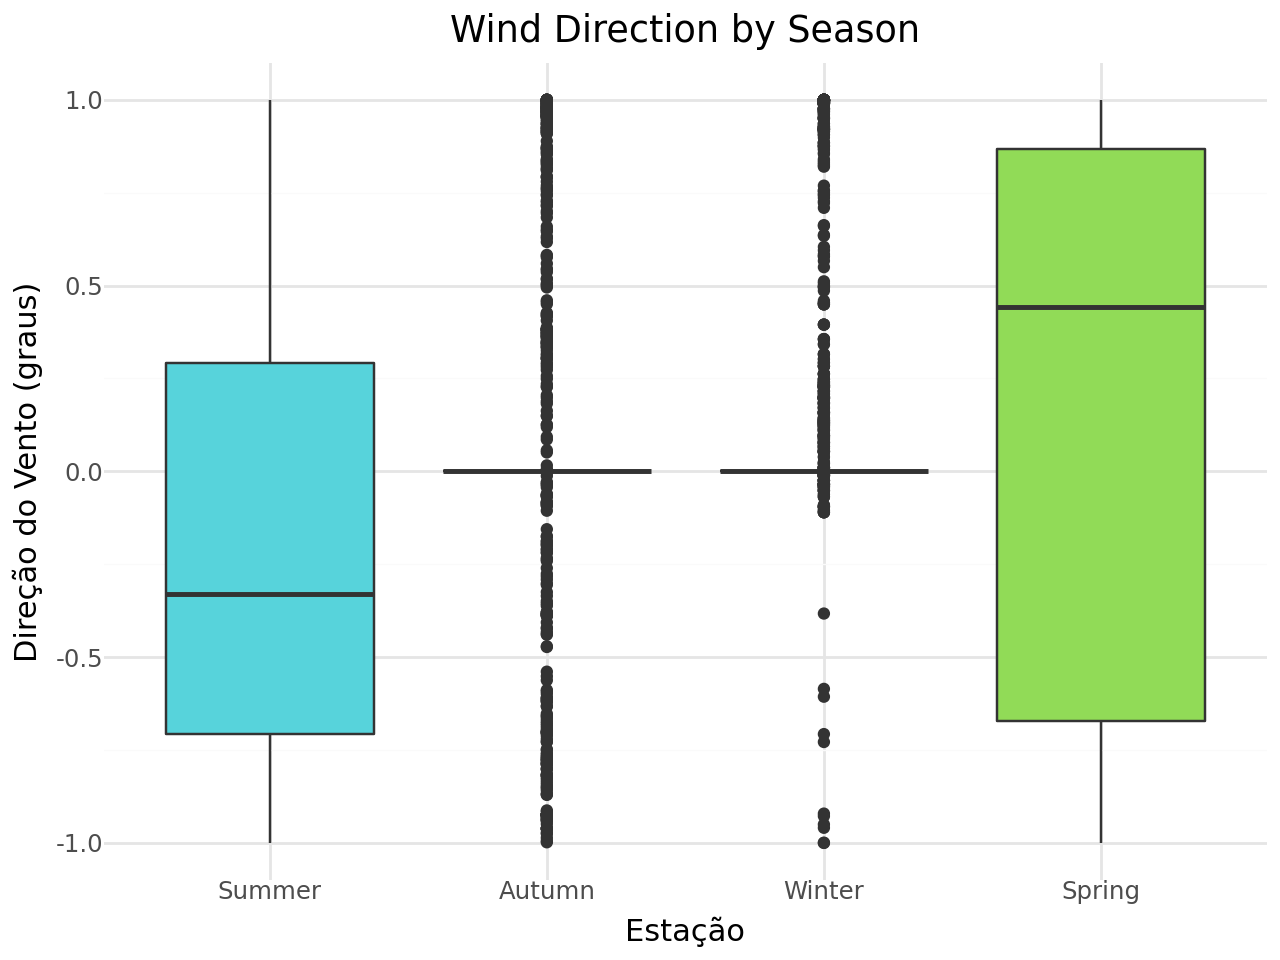

In [28]:
plot = (
    ggplot(df, aes(x='Season', y='Wind_Dir_Sin', fill='Season'))
    + geom_boxplot(show_legend=False)
    + scale_x_discrete(limits=season_order)  # aqui
    + theme_minimal()
    + labs(
        title='Wind Direction by Season',
        x='Estação',
        y='Direção do Vento (graus)'
    )
)
plot.show()

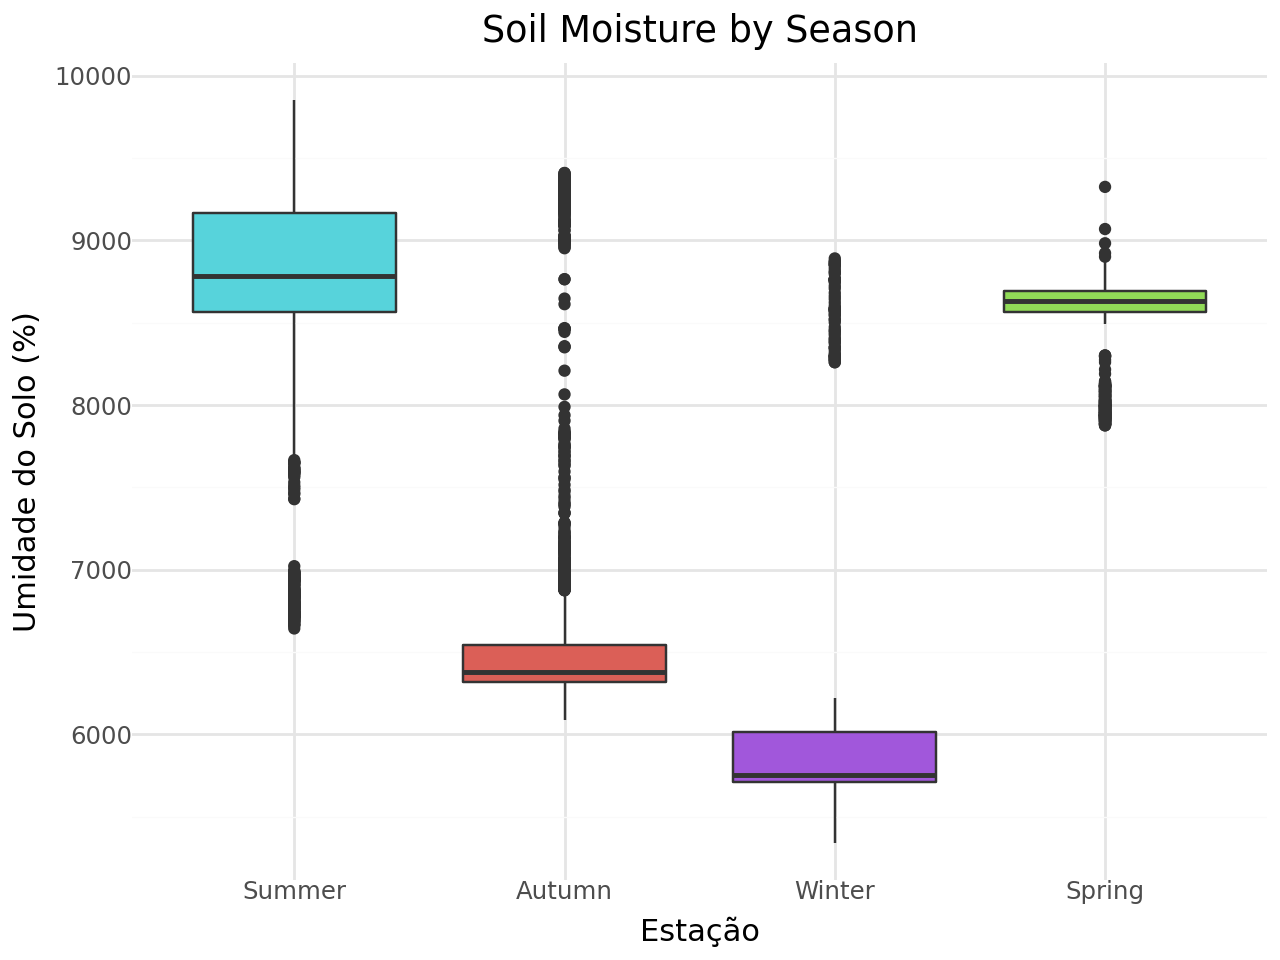

In [29]:
plot = (
    ggplot(df, aes(x='Season', y='Soil_Moisture', fill='Season'))
    + geom_boxplot(show_legend=False)
    + scale_x_discrete(limits=season_order)  # aqui
    + theme_minimal()
    + labs(
        title='Soil Moisture by Season',
        x='Estação',
        y='Umidade do Solo (%)'
    )
)
plot.show()

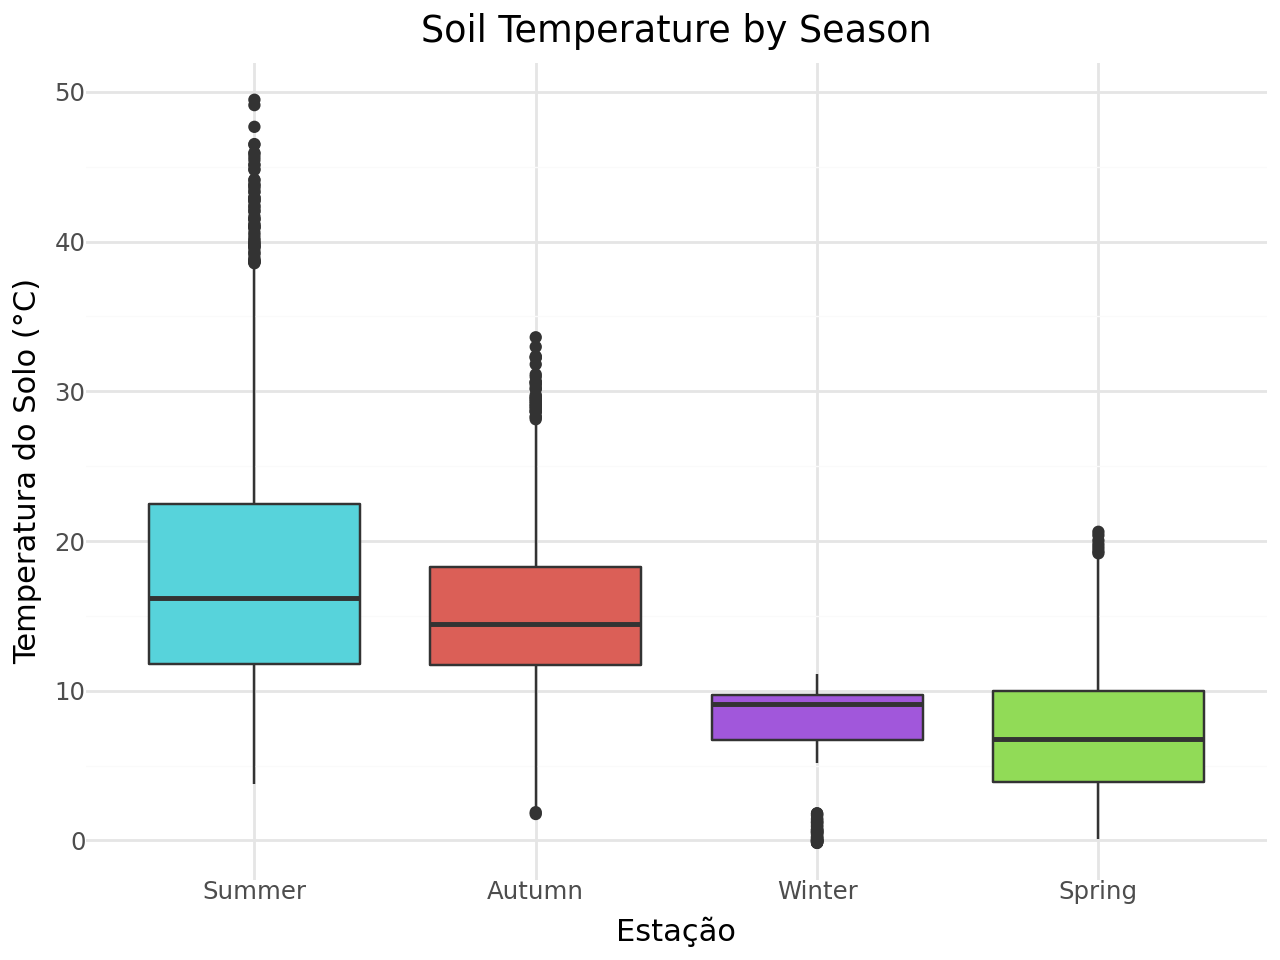

In [30]:
plot = (
    ggplot(df, aes(x='Season', y='Soil_Temperature', fill='Season'))
    + geom_boxplot(show_legend=False)
    + scale_x_discrete(limits=season_order)  # aqui
    + theme_minimal()
    + labs(
        title='Soil Temperature by Season',
        x='Estação',
        y='Temperatura do Solo (°C)'
    )
)
plot.show()